In [1]:
import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir(os.pardir)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsmath}',
                     'font.family': 'serif'})
import numpy as np
#np.random.seed(0)
import pandas as pd
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.augmentations import RegressionSMOTE
import seaborn as sns
sns.set(style='ticks', font='serif')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
PATH_PROC_DATA = os.path.join('data', 'processed')
true_data = pd.read_csv(os.path.join(PATH_PROC_DATA, 'pDeltaT_clean.csv'))
syn_data = pd.read_csv(os.path.join(PATH_PROC_DATA, 'pDeltaT_synthetic.csv'))

features = ['d [mm]', 'f [GHz]', 'psPDtot_1 [W/m2]', 'psPDtot_4 [W/m2]']
target = 'pDeltaT * 100 [°C]'
X = syn_data[features].to_numpy()
y = syn_data[target].to_numpy() / 100
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y[:, np.newaxis],
                                                    test_size=.2)
X_eval = true_data[features].to_numpy()
y_eval = true_data[target].to_numpy() / 100

In [10]:
reg = TabNetRegressor(n_d=32,
                      n_a=32,
                      n_steps=3,
                      gamma=1.3,
                      n_independent=3,
                      n_shared=3,
                      momentum=0.02,
                      lambda_sparse=0.001,
                      clip_value=1,
                      verbose=0,
                      mask_type='sparsemax')

In [11]:
aug = RegressionSMOTE(p=0.3)

In [15]:
reg.fit(X_train=X_train, y_train=y_train,
        eval_set=[(X_test, y_test)],
        eval_name=['test'],
        eval_metric=['mae', 'mse', 'rmse', 'rmsle'],
        max_epochs=10000,
        patience=1000,
        batch_size=64,
        virtual_batch_size=64,
        num_workers=0,
        drop_last=False,
        augmentations=aug) 


Early stopping occurred at epoch 1342 with best_epoch = 342 and best_test_rmsle = 0.00509


/home/alk/miniconda3/envs/ursi/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [17]:
y_pred = reg.predict(X_eval)
rmse = np.sqrt(mean_squared_error(y_eval, y_pred.ravel()))

y_resid = (y_eval - y_pred.ravel())
ae = np.abs(y_resid)
mae = np.mean(ae)
mae

0.05797859352444012

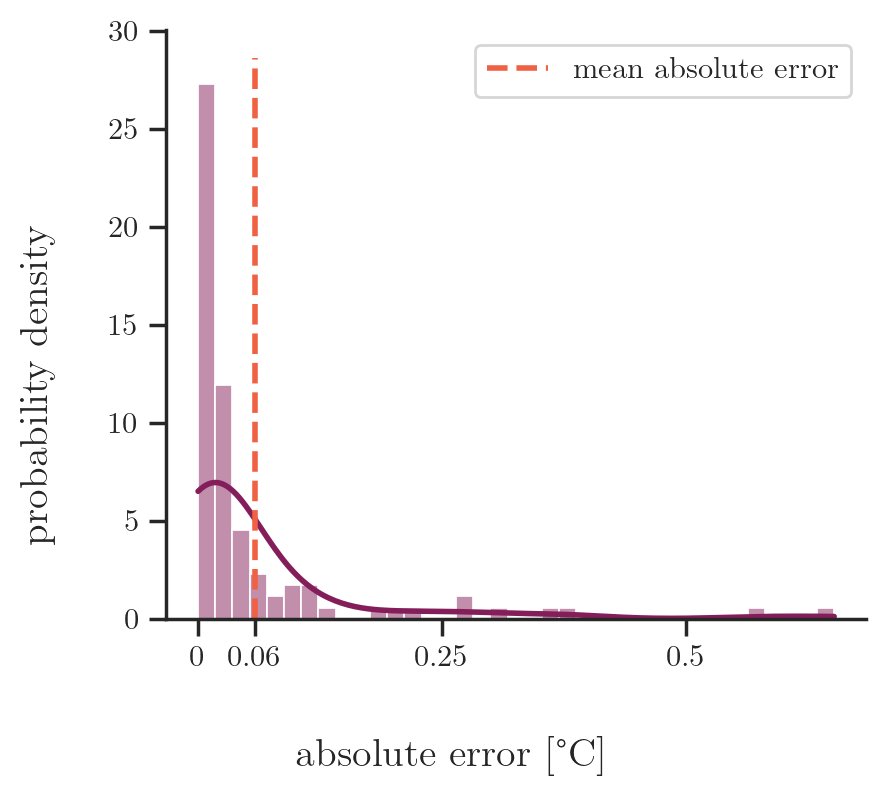

In [18]:
cs = sns.color_palette('rocket', 2)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
ax = sns.histplot(x=ae,
                  color=cs[0], stat='density', kde=True, ax=ax,
                  line_kws={'lw': 2})
ax.vlines(mae, *ax.get_ybound(), colors=cs[1], ls='--', lw=2,
          label='mean absolute error')
ax.legend()
ax.set(xlabel='', ylabel='',
       xticks=[0, mae, 0.25, 0.5],
       xticklabels=[0, round(mae, 2), 0.25, 0.5],
       #xlim=[0, 0.5],
       #yticks=[0, 7, 14],
       #yticklabels=[0, 7, 14],
       #ylim=[0, 14]
      )

fig.supxlabel('absolute error [°C]')
fig.supylabel('probability density')
fig.tight_layout()
sns.despine()

# fig_name = os.path.join('figures', '03_2_ape_dist.png')
# fig.savefig(fig_name, dpi=200, bbox_inches='tight')